# Install libraries

In [4]:
!pip install qiskit==0.43.0
!pip install qiskit-aer==0.12.0
!pip install networkx
!pip install matplotlib
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
from collections import defaultdict
from operator import itemgetter
from scipy.optimize import minimize
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer

# Generate a xy coordinates to create a  connected graph

Generated 40 edges for 20 nodes: [(7, 17), (6, 15), (14, 16), (5, 7), (3, 16)] ...


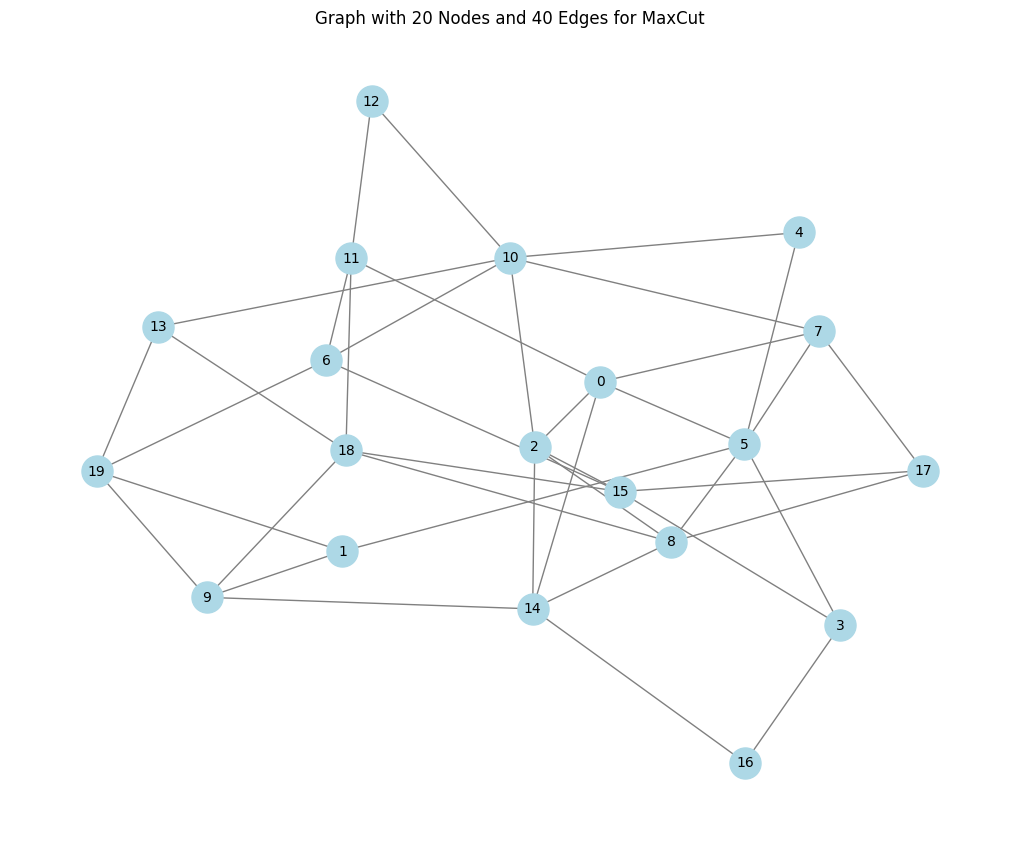

In [17]:
n_nodes = 20
n_edges = 40
coord_set= set()

while len(coord_set) < n_edges:
    u = random.randint(0, n_nodes - 1)
    v = random.randint(0, n_nodes - 1)
    if u != v:
        coord_set.add((min(u, v), max(u, v)))
coord_set = list(coord_set)[:n_edges]

print(f"Generated {len(coord_set)} edges for {n_nodes} nodes:", coord_set[:5], "...")

G = nx.Graph()
G.add_nodes_from(range(n_nodes))
G.add_edges_from(coord_set)
plt.figure(figsize=(10, 8))
nx.draw(G, pos=nx.spring_layout(G), with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
plt.title(f"Graph with {n_nodes} Nodes and {n_edges} Edges for MaxCut")
plt.show()

# MaxCut cost function

In [18]:
def maxcut_cost(solution, graph):
    cut = 0
    for u, v in graph.edges():
        if solution[u] != solution[v]:
            cut += 1
    return -cut

# QAOA Function

In [19]:
def qaoa_cir(graph, gamma, beta):
    n = n_nodes
    qc = QuantumCircuit(n, n)


    qc.h(range(n))

# cost hamiltonian
    for u, v in graph.edges():
        qc.cx(u, v)
        qc.rz(2 * gamma, v)
        qc.cx(u, v)

    # Mixer Hamiltonian
    qc.rx(2 * beta, range(n))


    qc.measure(range(n), range(n))
    return qc

#  classical optimization of parameters

In [20]:
def qaoa_objective(params, graph):
    gamma, beta = params
    shots = 2048
    qc = qaoa_cir(graph, gamma, beta)
    backend = Aer.get_backend('qasm_simulator')
    result = execute(qc, backend, shots=shots).result()
    counts = result.get_counts()

    avg_cost = 0
    for bitstring, count in counts.items():
        solution = [int(bit) for bit in bitstring]
        avg_cost += maxcut_cost(solution, graph) * count
    return avg_cost / shots


# QAOA with optimized parameters

In [21]:
initial_params = np.array([0.5, 0.5])
result = minimize(qaoa_objective, initial_params, args=(G,), method='COBYLA', options={'maxiter': 100})
optimal_params = result.x
print("Optimal parameters (gamma, beta):", optimal_params)
shots = 2048
qc = qaoa_cir(G, optimal_params[0], optimal_params[1])
backend = Aer.get_backend('qasm_simulator')
result = execute(qc, backend, shots=shots).result()
counts = result.get_counts()


Optimal parameters (gamma, beta): [2.74054529 0.24523847]


# Plotting

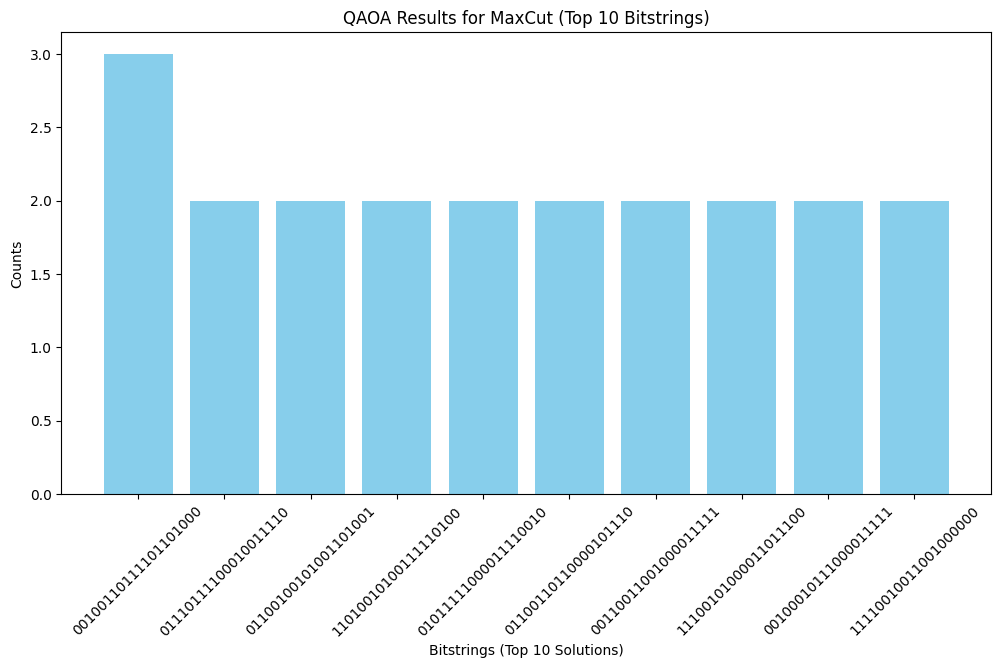

In [22]:
top_counts = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True)[:10])
plt.figure(figsize=(12, 6))
plt.bar(top_counts.keys(), top_counts.values(), color='skyblue')
plt.xlabel('Bitstrings (Top 10 Solutions)')
plt.ylabel('Counts')
plt.title('QAOA Results for MaxCut (Top 10 Bitstrings)')
plt.xticks(rotation=45)
plt.show()


# best quantum solution

In [23]:
best_solution = max(counts.items(), key=lambda x: -maxcut_cost([int(b) for b in x[0]], G))
best_bitstring, best_count = best_solution
best_quantum_cut_value = -maxcut_cost([int(b) for b in best_bitstring], G)
print(f"Best quantum solution: {best_bitstring}, Cut value: {best_quantum_cut_value}, Occurrences: {best_count}")


Best quantum solution: 01110111000011100110, Cut value: 31, Occurrences: 1


# Classical Solution approximation

In [24]:
partition = nx.algorithms.approximation.maxcut.one_exchange(G)  #
cut_set_1, cut_set_2 = partition
# Convert partition to a binary solution (0 for cut_set_1, 1 for cut_set_2)
classical_solution = [0] * n_nodes
for node in cut_set_2[1]:
    classical_solution[node] = 1
best_classical_cut = -maxcut_cost(classical_solution, G)
print(f"Classical heuristic solution cut value: {best_classical_cut}")

Classical heuristic solution cut value: 32


# Quantum accuracy

In [25]:

accuracy = (best_quantum_cut_value / best_classical_cut) * 100
print(f"Accuracy of quantum solution compared to classical heuristic: {accuracy:.2f}%")


Accuracy of quantum solution compared to classical heuristic: 96.88%
